In [1]:
%pylab inline
import platform
import IPython
import sklearn as sk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print ('Python version:', platform.python_version())
print ('IPython version:', IPython.__version__)
print ('numpy version:', np.__version__)
print ('scikit-learn version:', sk.__version__)
print ('matplotlib version:', matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib
Python version: 3.5.2
IPython version: 4.0.1
numpy version: 1.13.1
scikit-learn version: 0.18.2
matplotlib version: 1.5.0


In the previous chapters we have studied several algorithms for very different tasks,
from classification and regression to clustering and dimensionality reduction. We
showed how we can apply these algorithms to predict results when faced with new
data. That is what machine learning is all about. In this last chapter, we want to show
some important concepts and methods you should take into account if you want to
do real-world machine learning.
- In real-world problems, usually data is not already expressed by attribute/
float value pairs, but through more complex structures or is not structured at
all. We will learn __feature extraction__ techniques that will allow us to extract
scikit-learn features from data.
- From the initial set of available features, not all of them will be useful
for our algorithms to learn from; in fact, some of them may degrade our
performance. We will address the problem of selecting the most adequate
feature set, a process known as __feature selection__.
- Finally, as we have seen in the examples in this book, many of the machine
learning algorithms have parameters that must be set in order to use them.
To do that, we will review __model selection__ techniques; that is, methods to
select the most promising hyperparameters to our algorithms. 

# Feature extraction

...the source data does not usually come in this format. We have to
extract what we think are potentially useful features and convert them to our learning
format. This process is called feature extraction or feature engineering, and it is an
often underestimated but very important and time-consuming phase in most realworld
machine learning tasks. We can identify two different steps in this task:
 - __Obtain features__: This step involves processing the source data and extracting
the learning instances, usually in the form of feature/value pairs where
the value can be an integer or float value, a string, a categorical value, and
so on. The method used for extraction depends heavily on how the data
is presented. For example, we can have a set of pictures and generate an
integer-valued feature for each pixel, indicating its color level, as we did
in the face recognition example in Chapter 2, Supervised Learning. Since this
is a very task-dependent job, we will not delve into details and assume we
already have this setting for our examples.
 - __Convert features__: Most scikit-learn algorithms assume as an input a set of
instances represented as a list of float-valued features. How to get these
features will be the main subject of this section.

We can, as we did in Chapter 2, Supervised Learning, build ad hoc procedures to
convert the source data. There are, however, tools that can help us to obtain a
suitable representation. The Python package __pandas__ (http://pandas.pydata.
org/), for example, provides data structures and tools for data analysis. It aims to
provide similar features to those of R, the popular language and environment for
statistical computing. We will use pandas to import the Titanic data we presented in
Chapter 2, Supervised Learning, and convert them to the scikit-learn format.

In [2]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [32]:
titanic = pd.read_csv('data/titanic.csv')
print (titanic[:5])

   row.names pclass  survived  \
0          1    1st         1   
1          2    1st         0   
2          3    1st         0   
3          4    1st         0   
4          5    1st         1   

                                              name      age     embarked  \
0                     Allen, Miss Elisabeth Walton  29.0000  Southampton   
1                      Allison, Miss Helen Loraine   2.0000  Southampton   
2              Allison, Mr Hudson Joshua Creighton  30.0000  Southampton   
3  Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)  25.0000  Southampton   
4                    Allison, Master Hudson Trevor   0.9167  Southampton   

                         home.dest room      ticket   boat     sex  
0                     St Louis, MO  B-5  24160 L221      2  female  
1  Montreal, PQ / Chesterville, ON  C26         NaN    NaN  female  
2  Montreal, PQ / Chesterville, ON  C26         NaN  (135)    male  
3  Montreal, PQ / Chesterville, ON  C26         NaN    NaN  female  

In [6]:
print (titanic.head()[['pclass', 'survived', 'age', 'embarked',
'boat', 'sex']])

  pclass  survived      age     embarked   boat     sex
0    1st         1  29.0000  Southampton      2  female
1    1st         0   2.0000  Southampton    NaN  female
2    1st         0  30.0000  Southampton  (135)    male
3    1st         0  25.0000  Southampton    NaN  female
4    1st         1   0.9167  Southampton     11    male


The main difficulty we have now is that scikit-learn methods expect real numbers
as feature values. In Chapter 2, Supervised Learning, we used the LabelEncoder and
OneHotEncoder preprocessing methods to manually convert certain categorical
features into 1-of-K values (generating a new feature for each possible value; valued
1 if the original feature had the corresponding value and 0 otherwise). This time, we
will use a similar scikit-learn method, __DictVectorizer__, which automatically builds
these features from the different original feature values. Moreover, we will program
a method to encode a set of columns in a unique step.

In [7]:
from sklearn import feature_extraction

def one_hot_dataframe(data, cols, replace=False):
    vec = feature_extraction.DictVectorizer()
    mkdict = lambda row: dict((col, row[col]) for col in cols)
    vecData = pd.DataFrame(vec.fit_transform( data[cols].apply(mkdict, axis=1)).toarray())
    vecData.columns = vec.get_feature_names()
    vecData.index = data.index
    if replace:
        data = data.drop(cols, axis=1)
        data = data.join(vecData)
    return (data, vecData)

The one_hot_dataframe method (based on the script at https://gist.github.
com/kljensen/5452382) takes a pandas DataFrame data structure and a list of
columns and encodes each column into the necessary 1-of-K features. If the replace
parameter is True, it will also substitute the original column with the new set. Let's
see it applied to the categorical pclass, embarked, and sex features (titanic_n only
contains the previously created columns):

In [34]:
titanic,titanic_n = one_hot_dataframe(titanic, ['pclass', 'embarked', 'sex'], replace=True)
titanic.describe()

,row.names,survived,age,embarked,embarked=Cherbourg,embarked=Queenstown,embarked=Southampton,pclass=1st,pclass=2nd,pclass=3rd,sex=female,sex=male
count,1313.000000,1313.000000,633.000000,821,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000
mean,657.000000,0.341965,31.194181,0,0.154608,0.034273,0.436405,0.245240,0.213252,0.541508,0.352628,0.647372
std,379.174762,0.474549,14.747525,0,0.361668,0.181998,0.496128,0.430393,0.409760,0.498464,0.477970,0.477970
min,1.000000,0.000000,0.166700,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,329.000000,0.000000,21.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,657.000000,0.000000,30.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,985.000000,1.000000,41.000000,0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1313.000000,1.000000,71.000000,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The pclass attribute has been converted to three pclass=1st, pclass=2nd,
pclass=3rd features, and similarly for the other two features. Note that the
embarked feature has not disappeared, This is due to the fact that the original
embarked attribute included NaN values, indicating a missing value; in those cases,
every feature based on embarked will be valued 0, but the original feature whose
value is NaN remains, indicating the feature is missing for certain instances. Next, we
encode the remaining categorical attributes:

In [35]:
titanic, titanic_n = one_hot_dataframe(titanic, ['home.dest', 'room', 'ticket', 'boat'], replace=True)

In [36]:
titanic.describe()

,row.names,survived,age,embarked,embarked=Cherbourg,embarked=Queenstown,embarked=Southampton,pclass=1st,pclass=2nd,pclass=3rd,...,ticket=248744 L13,ticket=248749 L13,ticket=250647,ticket=27849,ticket=28220 L32 10s,ticket=34218 L10 10s,ticket=36973 L83 9s 6d,ticket=392091,ticket=7076,ticket=L15 1s
count,1313.000000,1313.000000,633.000000,821,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,...,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000
mean,657.000000,0.341965,31.194181,0,0.154608,0.034273,0.436405,0.245240,0.213252,0.541508,...,0.000762,0.000762,0.000762,0.000762,0.002285,0.000762,0.001523,0.001523,0.000762,0.000762
std,379.174762,0.474549,14.747525,0,0.361668,0.181998,0.496128,0.430393,0.409760,0.498464,...,0.027597,0.027597,0.027597,0.027597,0.047764,0.027597,0.039014,0.039014,0.027597,0.027597
min,1.000000,0.000000,0.166700,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,329.000000,0.000000,21.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,657.000000,0.000000,30.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,985.000000,1.000000,41.000000,0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1313.000000,1.000000,71.000000,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We also have to deal with missing values, since DecisionTreeClassifier we plan
to use does not admit them on input. Pandas allow us to replace them with a fixed
value using the fillna method. We will use the mean age for the age feature, and 0
for the remaining missing attributes.

In [37]:
mean = titanic['age'].mean()
titanic['age'].fillna(mean, inplace=True)
titanic.fillna(0, inplace=True)

Now, all of our features (except for Name) are in a suitable format. We are ready to
build the test and training sets, as usual.

In [39]:
from sklearn.cross_validation import train_test_split
titanic_target = titanic['survived']
titanic_data = titanic.drop(['name', 'row.names', 'survived'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(titanic_data, titanic_target, test_size=0.25, random_state=33)

We decided to simply drop the name attribute, since we do not expect it to be
informative about the survival status (we have one different value for each instance,
so we can generalize over it). We also specified the survived feature as the target
class, and consequently eliminated it from the training vector.
Let's see how a decision tree works with the current feature set.

In [40]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='entropy')
dt = dt.fit(X_train, y_train)
from sklearn import metrics
y_pred = dt.predict(X_test)
print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred)), "\n")

Accuracy:0.833 



# Feature selection

Until now, when training our decision tree, we used every available feature in our
learning dataset. This seems perfectly reasonable, since we want to use as much
information as there is available to build our model. There are, however, two main
reasons why we would want to __restrict the number of features used__:
 - Firstly, for some methods, especially those (such as decision trees) that
reduce the number of instances used to refine the model at each step, it is
possible that irrelevant features could suggest correlations between features
and target classes that arise just by chance and do not correctly model the
problem. This aspect is also related to __overfitting__; having certain over-specific
features may lead to poor generalization. Besides, some features may be
highly correlated, and will simply add redundant information.
 - The second reason is a real-world one. A large number of features could
greatly increase the __computation time__ without a corresponding classifier
improvement. This is of particular importance when working with Big Data,
where the number of instances and features could easily grow to several
thousand or more. Also, in relation to the curse of dimensionality, learning
a generalizable model from a dataset with too many features relative to the
number of instances can be difficult.

As a result, working with a smaller feature set may lead to better results. So we want
to find some way to algorithmically find the best features. This task is called feature
selection and is a crucial step when we aim to get decent results with machine
learning algorithms. If we have poor features, our algorithm will return poor results
no matter how sophisticated our machine learning algorithm is.

Consider, for example, our very simple Titanic example. We started with just 11
features, but after 1-of-K encoding they grew to 581.

In [42]:
print (titanic.head())

   row.names  survived                                             name  \
0          1         1                     Allen, Miss Elisabeth Walton   
1          2         0                      Allison, Miss Helen Loraine   
2          3         0              Allison, Mr Hudson Joshua Creighton   
3          4         0  Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)   
4          5         1                    Allison, Master Hudson Trevor   

       age  embarked  embarked=Cherbourg  embarked=Queenstown  \
0  29.0000         0                   0                    0   
1   2.0000         0                   0                    0   
2  30.0000         0                   0                    0   
3  25.0000         0                   0                    0   
4   0.9167         0                   0                    0   

   embarked=Southampton  pclass=1st  pclass=2nd      ...        \
0                     1           1           0      ...         
1                     1   

This does not pose an important computational problem, but consider what could
happen if, as previously demonstrated, we represent each document in a dataset as
the number of occurrences of each possible word. Another problem is that decision
trees suffer from overfitting. If branching is based on a very small number of
instances, the prediction power of the built model will decrease on future data. One
solution to this is to adjust model parameters (such as the maximum tree depth or
the minimum required number of instances at a leaf node). In this example, however,
we will take a different approach: we will try to limit the features to the most
relevant ones.

What do we mean by relevant? This is an important question. A general approach
is to find the smallest set of features that correctly characterize the training data. If
a feature always coincides with the target class (that is, it is a perfect predictor), it is
enough to characterize the data. On the other hand, if a feature always has the same
value, its prediction power will be very low.

The general approach in feature selection is to get some kind of evaluation function
that, when given a potential feature, returns a score of how useful the feature is,
and then keeps the features with the highest scores. These methods may have the
disadvantage of not detecting correlations between features. Other methods may
be more brute force: try all possible subsets of the original feature list, train the
algorithm on each combination, and keep the combination that gets the best results.

As an evaluation method, we can, for instance, use a statistical test that measures
how probable it is that two random variables (say, a given feature and the target
class) are independent; that is, there is no correlation between them.

Scikit-learn provides several methods in the __feature_selection module__. We will
use the __SelectPercentile__ method that, when given a statistical test, selects a userspecified
percentile of features with the highest scoring. __The most popular statistical
test is the χ² (chi-squared) statistic__. Let's see how it works for our Titanic example; we
will use it to select 20 percent of the most important features:

In [43]:
from sklearn import feature_selection
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=20)
X_train_fs = fs.fit_transform(X_train, y_train)

The X_train_fs array now has the statistically more important features. We can
now train our decision tree on this data.

In [45]:
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
y_pred_fs = dt.predict(X_test_fs)
print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred_fs)),"\n")

Accuracy:0.848 



We can see that the accuracy on the training set improved half a point after feature
selection on the training set.

Is it possible to find the optimal number of features? If by optimal we mean with
the best performance on the training set, it is actually possible; we can simply use
a brute-force approach and try with different numbers of features while measuring
their performance on the training set using cross-validation.

1 0.83332302618
6 0.87804576376
11 0.872984951556
16 0.872974644403
21 0.870933828077
26 0.869913419913
31 0.86381158524
36 0.866883116883
41 0.873984745413
46 0.877045969903
51 0.86990311276
56 0.867862296434
61 0.870933828077
66 0.872974644403
71 0.866852195424
76 0.865842094414
81 0.868934240363
86 0.863821892393
91 0.86687280973
96 0.866862502577
Optimal number of features:6 



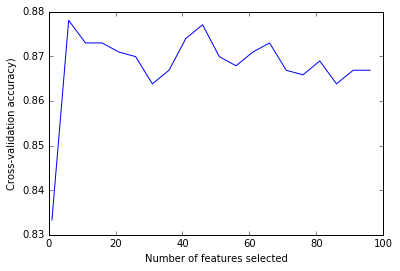

In [91]:
from sklearn import cross_validation

percentile_step = 5 # try 1, 2, 5, 10, etc.

percentiles = range(1, 100, percentile_step)
results = []
for i in range(1,100,percentile_step):
    fs = feature_selection.SelectPercentile(
        feature_selection.chi2, percentile=i)
    X_train_fs = fs.fit_transform(X_train, y_train)
    scores = cross_validation.cross_val_score(dt, X_train_fs, y_train, cv=5)
    print (i, scores.mean())
    results = np.append(results, scores.mean())

optimal_percentil = np.where(results == results.max())[0]
print ("Optimal number of features:{0}".format(percentiles[optimal_percentil[0]]), "\n")

# Plot number of features VS. cross-validation scores
import pylab as pl
pl.figure()
pl.xlabel("Number of features selected")
pl.ylabel("Cross-validation accuracy)")
pl.plot(percentiles, results)

We can see that accuracy quickly improves when we start adding features, remaining
stable after the percentile of features turns about 10. In fact, the best accuracy is
achieved when using 64 of the original 581 features (at the 11 percent percentile).
Let's see if this actually improved performance on the testing set.

Note: results are diffrent from statement above. Probably Python 2 and Python 3 calculate _little difffrent_

In [93]:
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=percentiles[optimal_percentil[0]])
X_train_fs = fs.fit_transform(X_train, y_train)
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
y_pred_fs = dt.predict(X_test_fs)
print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y_test, y_pred_fs)), "\n")

Accuracy:0.863 



The performance improved slightly, again. Compared with our initial performance,
we have finally improved by almost one accuracy point using only 11 percent of
the features.

The reader may have noted that while creating our classifier, we used the default
parameters, except for the splitting criterion, where we have used entropy. Can we
improve our model using different parameters? This task is called model selection,
and we will address it in detail in the next section using a different learning example.

For now, let's just test if the alternative method (gini) would result in better
performance for our example. To do this, we will again use cross-validation.

In [94]:
dt = tree.DecisionTreeClassifier(criterion='entropy')
scores = cross_validation.cross_val_score(dt, X_train_fs, y_train, cv=5)
print ("Entropy criterion accuracy on cv: {0:.3f}".format(scores.mean()))
dt = tree.DecisionTreeClassifier(criterion='gini')
scores = cross_validation.cross_val_score(dt, X_train_fs, y_train, cv=5)
print ("Gini criterion accuracy on cv: {0:.3f}".format(scores.mean()))

Entropy criterion accuracy on cv: 0.877
Gini criterion accuracy on cv: 0.880


The Gini criterion performs better on our training set. How about its performance on
the test set?

In [95]:
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
y_pred_fs = dt.predict(X_test_fs)
print ("Accuracy: {0:.3f}".format(metrics.accuracy_score(y_test,y_pred_fs)),"\n")

Accuracy: 0.863 



It seems that performance improvement on the training set did not hold for the
evaluation set. This is always possible. In fact, performance could have decreased
(recall overfitting). Our model is still the best. If we changed our model to use the one
with the best performance in the testing set, we can never measure its performance,
since the testing dataset could not be considered "unseen data" anymore.